# A4 Convolutional Neural Networks

Brent Staab

## Instructions

In this assignment, you will finish writing this new class, named `NeuralNetwork_Convolutional` that uses the `torch.nn` module to construct neural networks with initial convolutional layers followed by fully connected layers to learn to classify images.  Your main job is to finish the `train` function, following steps shown in lecture notes.

The network will have some number, possibly zero, layers of convolutional units having the `tanh` activation function.  These are followed by one or more layers with fully connected units with `tanh` activation functions.

A tricky part of building this structure is determining the correct number of inputs to the first fully-connected layer.  This requires knowing the size of the output image generated by the last convolutional layer.  If this layer produces an output image that is $n\times n$ and it has $m$ units, then the concatenation of all image values for all units into one vector to form the input to the fully-connected layer, the resulting vector will be $m \cdot n^2$.

As an example, say our data contains images that are $d\times d$ and we have a neural network with two convolutional layers and one fully connected layer. 

Original input image: 
- $d\times d$ of $c$ channels

First convolutional layer with $u_1$ units having kernels sized $k_1\times k_1$ and strides of $s_1$
- input is $d\times d$ of $c$ channels
- output is $z_1\times z_1$ of $u_1$ channels, where $z_1 = \frac{d - k_1}{s_1} + 1$

Second convolutional layer with $u_2$ units having kernels sized $k_2\times k_2$ and strides of $s_2$
- input is $z_1\times z_1$ of $u_1$ channels
- output is $z_2\times z_2$ of $u_2$ channels, where $z_2 = \frac{z_1 - k_2}{s_2} + 1$


Third convolutional layer is fully-connected, so we must flatten into a vector the output from the previous convolutional layer. Say this layer has $u_3$ units.
- input is $u_2 \, z_2 ^ 2$
- output is $u_3$ values

## Import code needed in this notebook

In [1]:
import numpy as np
import torch
import time
import copy
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import pickle, gzip

## Definition of `NeuralNetwork_Convolutional`

In [2]:
class NeuralNetwork_Convolutional():
    # Initilization function (a.k.a. constructor) for object
    def __init__(self, 
                 n_channels_in_image,         # (int) number of values per pixel 
                 image_size,                  # (int) number of rows in image, same as number of columns
                 n_units_in_conv_layers,      # (list of ints) number of units in each convolutional layer
                 kernels_size_and_stride,     # (list of lists) each list is [kernel_size, kernel_stride] for each convolutional layer
                 n_units_in_fc_hidden_layers, # (list of ints) number of units in fully-connected layers
                 classes,                     # (list of ints) labels for each class
                 use_gpu=False):              # (boolean) flag indicating GPU use or not (default = no GPU)

        if not isinstance(n_units_in_conv_layers, list):
            raise Exception('n_units_in_conv_layers must be a list')

        if not isinstance(n_units_in_fc_hidden_layers, list):
            raise Exception('n_units_in_fc_hidden_layers must be a list')
        
        if use_gpu and not torch.cuda.is_available():
            print('\nGPU is not available. Running on CPU.\n')
            use_gpu = False

        self.n_channels_in_image = n_channels_in_image
        self.image_size = image_size 
        self.n_units_in_conv_layers = n_units_in_conv_layers
        self.n_units_in_fc_hidden_layers = n_units_in_fc_hidden_layers
        self.kernels_size_and_stride = kernels_size_and_stride
        self.n_outputs = len(classes)
        self.classes = np.array(classes)
        self.use_gpu = use_gpu
        
        self.n_conv_layers = len(self.n_units_in_conv_layers)
        self.n_fc_hidden_layers = len(self.n_units_in_fc_hidden_layers)
      
        # Build the net layers
        self.nnet = torch.nn.Sequential()

        # Add convolutional layers
        n_units_previous = self.n_channels_in_image
        output_size_previous = self.image_size
        n_layers = 0
        if self.n_conv_layers > 0:

            for (n_units, kernel) in zip(self.n_units_in_conv_layers, self.kernels_size_and_stride):
                n_units_previous, output_size_previous = self._add_conv2d_tanh(n_layers,
                                        n_units_previous, output_size_previous, n_units, kernel)
                n_layers += 1 # for text label in layer
                
        self.nnet.add_module('flatten', torch.nn.Flatten())  # prepare for fc layers

        n_inputs = output_size_previous ** 2 * n_units_previous
        if self.n_fc_hidden_layers > 0:
            for n_units in self.n_units_in_fc_hidden_layers:
                n_inputs = self._add_fc_tanh(n_layers, n_inputs, n_units)
                n_layers += 1

        self.nnet.add_module(f'output_{n_layers}', torch.nn.Linear(n_inputs, self.n_outputs))
        
        # Define loss and optimizer functions
        self.loss_F = torch.nn.CrossEntropyLoss()
        
        # Member variables for standardization
        self.Xmeans = None
        self.Xstds = None

        if self.use_gpu:
            self.nnet.cuda()

        self.n_epochs = 0
        self.error_trace = []

    def _add_conv2d_tanh(self, n_layers, n_units_previous, output_size_previous,
                   n_units, kernel_size_and_stride):
        kernel_size, kernel_stride = kernel_size_and_stride
        self.nnet.add_module(f'conv_{n_layers}', torch.nn.Conv2d(n_units_previous, n_units,
                                                                 kernel_size, kernel_stride))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        output_size_previous = (output_size_previous - kernel_size) // kernel_stride + 1
        n_units_previous = n_units                
        return n_units_previous, output_size_previous
    
    def _add_fc_tanh(self, n_layers, n_inputs, n_units):
        self.nnet.add_module(f'linear_{n_layers}', torch.nn.Linear(n_inputs, n_units))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        n_inputs = n_units
        return n_inputs

    def __repr__(self):
        str = f'''{type(self).__name__}(
                            n_channels_in_image={self.n_channels_in_image},
                            image_size={self.image_size},
                            n_units_in_conv_layers={self.n_units_in_conv_layers},
                            kernels_size_and_stride={self.kernels_size_and_stride},
                            n_units_in_fc_hidden_layers={self.n_units_in_fc_hidden_layers},
                            classes={self.classes},
                            use_gpu={self.use_gpu})'''

        str += self.nnet
        if self.n_epochs > 0:
            str += f'\n   Network was trained for {self.n_epochs} epochs that took {self.training_time:.4f} seconds.'
            str += f'\n   Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str
        
    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

    def train(self, X, T, n_epochs, learning_rate=0.01):

        start_time = time.time()
        
        self.learning_rate = learning_rate

        if T.ndim == 1:
            T = T.reshape((-1, 1))

        _, T = np.where(T == self.classes)  # convert to labels from 0

        self._setup_standardize(X, T)
        X = self._standardizeX(X)

        X = torch.tensor(X)
        T = torch.tensor(T.reshape(-1))
        if self.use_gpu:
            X = X.cuda()
            T = T.cuda()

        optimizer = torch.optim.Adam(self.nnet.parameters(), lr=self.learning_rate)
        
        # You fill in the rest of the train function, following lecture notes example.
        for epoch in range(n_epochs):
            optimizer.zero_grad()

            Y = self.nnet(X)

            error = self.loss_F(Y, T)
            self.error_trace.append(error)
            if epoch % 5 == 0:
                print(f'Epoch {epoch} error {error:.5f}')

            error.backward()

            optimizer.step()
        
        self.training_time = time.time() - start_time
        
    def get_error_trace(self):
        return self.error_trace
    
    def _softmax(self, Y):
        mx = Y.max()
        expY = np.exp(Y - mx)
        denom = expY.sum(axis=1).reshape((-1, 1)) + sys.float_info.epsilon
        return expY / denom
    
    def use(self, X):
        self.nnet.eval()  # turn off gradients and other aspects of training
        X = self._standardizeX(X)
        X = torch.tensor(X)
        if self.use_gpu:
            X = X.cuda()

        Y = self.nnet(X)

        if self.use_gpu:
            Y = Y.cpu()
        Y = Y.detach().numpy()
        Yclasses = self.classes[Y.argmax(axis=1)].reshape((-1, 1))

        return Yclasses, self._softmax(Y)

## Example Helper functions

In [3]:
# Helper function to test a speific network configuration
def run_test(nuicl, ksas, unifhl, ug, nepoch, lr):
    torch.random.manual_seed(42)
    nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                       image_size=Xtrain.shape[2],
                                       n_units_in_conv_layers=nuicl,
                                       kernels_size_and_stride=ksas,
                                       n_units_in_fc_hidden_layers=unifhl,
                                       classes=np.unique(Ttrain),
                                       use_gpu=ug)
    nnet.train(Xtrain, Ttrain, nepoch, learning_rate=lr)
    Yclasses, Y = nnet.use(Xtest)
    n_correct = (Yclasses == Ttest).sum()
    
    return [n_correct, Yclasses, nnet.get_error_trace()]

In [4]:
# Helper function to print/plot results
def print_results(results):
    index = 0                                                 # Initialize counter variable
    pct_correct = []                                          # Initialize variable to store % coo
    for result in results:                                    # Process each result
        pct_correct.append(result[0]/Ttest.shape[0]*100)      # Get the % correct for this test
        print(f'Test {index} - {result[0]} out of {Ttest.shape[0]} samples or {result[0]/Ttest.shape[0]*100:.2f} percent.')
                                                              #
    Xvals = list(range(len(pct_correct)))                     # Get X values based on number of results
                                                              #
    plt.figure(figsize=(20, 5))                               # Set the overall plot size
    plt.subplot(1, 2, 1)                                      # Define plot area and select 1st subplot
    plt.title('Error Trace')                                  # Add subplot 1 title
    plt.xlabel('epoch')                                       # Add subplot 1 X-axis label
    plt.ylabel('MSE')                                         # Add subplot 1 Y-axis label
                                                              #
    index = 0                                                 # Initialize counter variable
    for result in results:                                    # Iterate over each result
        plt.plot(result[2], '-', label=f'Test {index}')       # Add first data set to plot
        index += 1                                            # Increment the count
                                                              #
    plt.legend()                                              # Enable the legend for subplot 1
    plt.grid(True)                                            # Enable the grid for subplot 1
                                                              #
    plt.subplot(1, 2, 2)                                      # Select 2nd subplot
    plt.title('NN Acuracy')                                   # Add subplot 2 title
    plt.xlabel('Test number')                                 # Add subplot 2 X-axis label
    plt.ylabel('% correct')                                   # Add subplot 2 Y-axis label
    plt.plot(Xvals, pct_correct, 'o-')                        # Add data set to plot
    axes = plt.gca()                                          # Get Current Axis for plot 2
    axes.set_ylim([0,100])                                    # Set Y-axis limits (0-100) for percentages
    plt.grid(True)                                            # Enable the grid for subplot 2

## Simple Example with Squares and Diamonds

Repeating the example from lecture notes.

In [5]:
def make_images(nEach):
    images = np.zeros((nEach * 2, 1, 20, 20))  # nSamples, nChannels, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(nEach * 2, 1))
    centers = np.zeros((nEach * 2, 2))
    for i in range(nEach * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < nEach:
            # squares
            images[i, 0, x - r:x + r, y + r] = 1.0
            images[i, 0, x - r:x + r, y - r] = 1.0
            images[i, 0, x - r, y - r:y + r] = 1.0
            images[i, 0, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, 0, range(x - r, x), range(y, y + r)] = 1.0
            images[i, 0, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, 0, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, 0, range(x, x + r), range(y - r, y)] = 1.0
            # images += np.random.randn(*images.shape) * 0.5
            T = np.ones((nEach * 2, 1))
            T[nEach:] = 2
    return images.astype(np.float32), T.astype(np.int)

This is a function that generates diamond and square images.  The input parameter 'nEach' tells how many images of each type to generate.  The output will be numpy array of image data and the corresponding target values.

In [6]:
Xtrain, Ttrain = make_images(500)
Xtest, Ttest = make_images(10)

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 1, 20, 20), (1000, 1), (20, 1, 20, 20), (20, 1))

This shows an example of generating training and test data using the helper function above.

In [7]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[5], # , 5],
                                   n_units_in_fc_hidden_layers=[2], # 10, 10],
                                   classes=[1, 2],
                                   kernels_size_and_stride=[[5, 2]], # , [4, 1]],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 50, learning_rate=0.01)

Epoch 0 error 0.78276
Epoch 5 error 0.63319
Epoch 10 error 0.57189
Epoch 15 error 0.53234
Epoch 20 error 0.49389
Epoch 25 error 0.42804
Epoch 30 error 0.29053
Epoch 35 error 0.20128
Epoch 40 error 0.16170
Epoch 45 error 0.12876


This is creating a neural network to process the images generated in the previous step.  It has a single convolutional layer with 5 units, and one hidden layer with two units.  The kernel size and stride are 5 and 2 respectively which means the 'mask' is five pixels wide and moves in chunks of two pixels at a time.  The network is then trained for 50 iterations, using the larger pool of data for it's input.  The output shows the error for every 5 iterations.

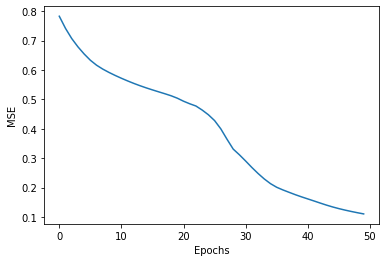

In [8]:
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

This is the graphical representation for each iteration of the training function.  The train function prints the values once every five iterations (see cell 7) but this shows the output for all iterations.  The MSE is still decreasing after 50 iterations and likely should be run longer to improve performance.

In [9]:
Yclasses, Y = nnet.use(Xtest)

print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.', end='')
print(f'  Training took {nnet.training_time:.3f} seconds.')

20 out of 20 test samples correctly classified.  Training took 0.536 seconds.


This shows the performance of a trained neural network with new, previousy unseen, data.  It is able to accurately predict 100% of the samples!

##### show_layer_output & show_layer_weights

Let's see what the output of the convolutional layer produces, and the weight matrices of each unit that produce those output images.   Here are functions, `show_layer_output` and `show_layer_weights` that will do this for us.

In [10]:
def show_layer_output(nnet, X_sample, layer):
    outputs = []
    reg = nnet.nnet[layer * 2].register_forward_hook(
        lambda self, i, o: outputs.append(o))
    nnet.use(X_sample)
    reg.remove()
    output = outputs[0]

    n_units = output.shape[1]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit+1)
        plt.imshow(output[0, unit, :, :].detach(),cmap='binary')
        plt.axis('off')
    return output

def show_layer_weights(nnet, layer):
    W = nnet.nnet[layer*2].weight.detach()
    n_units = W.shape[0]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit + 1)
        plt.imshow(W[unit, 0, :, :], cmap='binary')
        plt.axis('off')
    return W

(-0.5, 19.5, 19.5, -0.5)

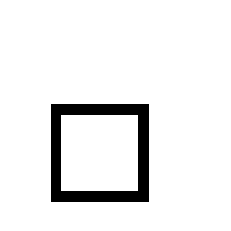

In [11]:
X_sample = Xtest[0:1, :, :, :]
plt.imshow(X_sample[0, 0, :, :], cmap='binary')
plt.axis('off')

This example extracts image data for a single sample from the test pool and plots it

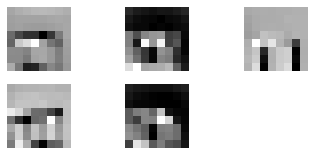

In [12]:
show_layer_output(nnet, X_sample, 0);

This is the layer output for the square image shown in cell 10.  Based on the images above, it looks like the samples are detecting the vertical and horizontal lines of the square.

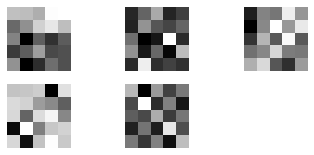

In [13]:
show_layer_weights(nnet, 0);

## MNIST Digits

Investigate the application of your code to the classification of MNIST digits, which you may download from [this site](http://deeplearning.net/tutorial/gettingstarted.html).

In [14]:
# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

This reads the MNIST data into three different tuples.  The train set is an array of data where each sample is an image of size 28x28 or 784 pixels.

In [15]:
Xtrain = train_set[0]
Ttrain = train_set[1]
Xtrain.shape, Ttrain.shape

((50000, 784), (50000,))

Extract the image and targed data from the unpickled MNIST dataset.  The training data is 50k images, each has 784 bits which is 28x28 pixels.  The target value size is 50k which represents the image value.

In [16]:
a = Xtrain[0, :].reshape(28, 28)
a.shape

(28, 28)

Extract an image and reshape from a flat 784 bits into a 28x28 array

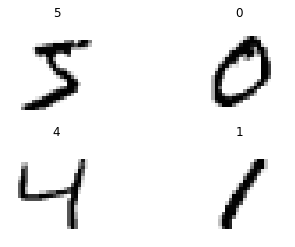

In [17]:
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(Xtrain[i, :].reshape(28, 28), cmap='binary')
    plt.title(Ttrain[i])
    plt.axis('off');

Extract the first four images, reshape into the correct dimensions and print.

## NeuralNetwork_Convolutional class validation
I'm using the first example from the A4grader.py script to enable direct comparison with a known result

In [18]:
traini = [3,  10,  13,  25,  28,  55,  69,  71, 101, 126, 2,   5,  14,  29,  31,  37,  39,  40,  46,  57, 1,  35,  38,  43,  47,  72,  77,  82, 106, 119]
testi = [136, 148, 157, 183, 188, 192, 194, 215, 246, 269,  74,  89,  94, 96, 107, 135, 137, 143, 145, 154, 147, 149, 172, 174, 186, 199, 208, 221, 222, 225]
Xtrain = test_set[0][traini, :].reshape(-1, 1, 28, 28)
Ttrain = test_set[1][traini].reshape(-1, 1)
Xtest = test_set[0][testi, :].reshape(-1, 1, 28, 28)
Ttest = test_set[1][testi].reshape(-1, 1)

In [19]:
np.unique(Ttrain)

array([0, 1, 2])

Generate the training and test data by indicating specific indices in the MNIST data set.

In [20]:
torch.random.manual_seed(42)
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[5, 5],
                                   kernels_size_and_stride=[[5, 3], [4, 2]],
                                   n_units_in_fc_hidden_layers=[10],
                                   classes=np.unique(Ttrain),
                                   use_gpu=False)

Create a neural network of the same configuration from A4grader.py.  Note, setting the random seed to a known value so we can directly compare with the A4grader output.

In [21]:
nnet.train(Xtrain, Ttrain, 20, learning_rate=0.01)

Epoch 0 error 1.11647
Epoch 5 error 0.69274
Epoch 10 error 0.31685
Epoch 15 error 0.15003


Train the neural network for twenty iterations using the training samples defined in cell 18 and a learning rate of 0.01.  It reaches a MSE of 0.15 at the last iteration.

In [22]:
Yclasses, Y = nnet.use(Xtest)
n_correct = (Yclasses == Ttest).sum()
print(f'{n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')

27 out of 30 samples, or 90.00 percent.


This cell shows the trained neural network correctly identified 90% of the images.  These are different than the training images and with only 20 iterations of training.  It's very likely that the performance would improve with more iterations.

## Required experiments  

Try different numbers of layers and units, kernel sizes and strides, and learning rates and epochs to get greater than 90% test images correctly classified.  Your grade will only depend on you showing various results, not on achieving this accuracy.
   
`NOTES`:  
* The 'run_test' helper function sets the random seed to '42' which is the same value used in A4grader.py.  This is done to to eliminate a variable and allow direct comparison between each test.  
* The first test of each experiment is a baseline configuration (from A4grader.py) so you can see how the changes affect the behavior.
* I use '%%capture' in each experiment to suppress the training output for each experiment.  The training data for all experiments will be plotted in a seperate cell.

#### Linear Network (no convolutional layers)

In [23]:
%%capture
results = []
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(    [], [[5, 3], [4, 2]],   [], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 28 out of 30 samples or 93.33 percent.


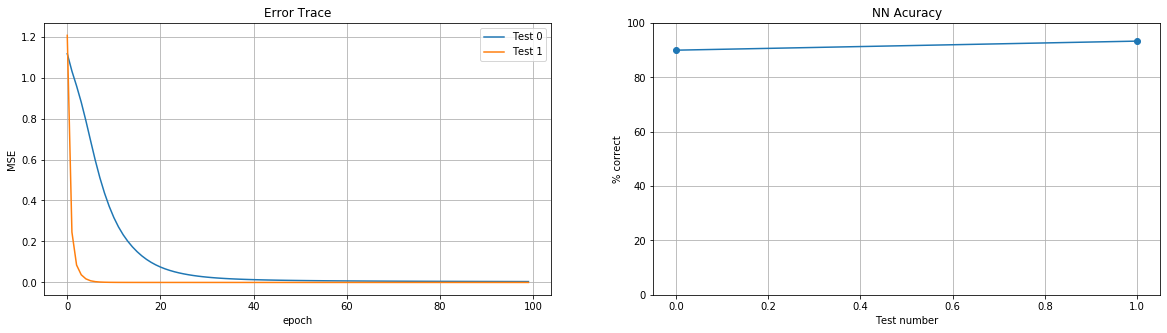

In [24]:
print_results(results)

The linear network, the one without any convolutional layers, performed slightly better than the baseline network.  It was able to correctly identify 93% of the samples while the baseline configuration correctly identified 90% or one less.  Also, it trains MUCH quicker.  It reaches an MSE of ~0 in less than 10 iterations while the baseline needs over 50.

#### Number of layers

In [25]:
%%capture
results = []
results.append(run_test(         [5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(            [5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(      [5, 5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(   [5, 5, 5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5, 5, 5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 28 out of 30 samples or 93.33 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.


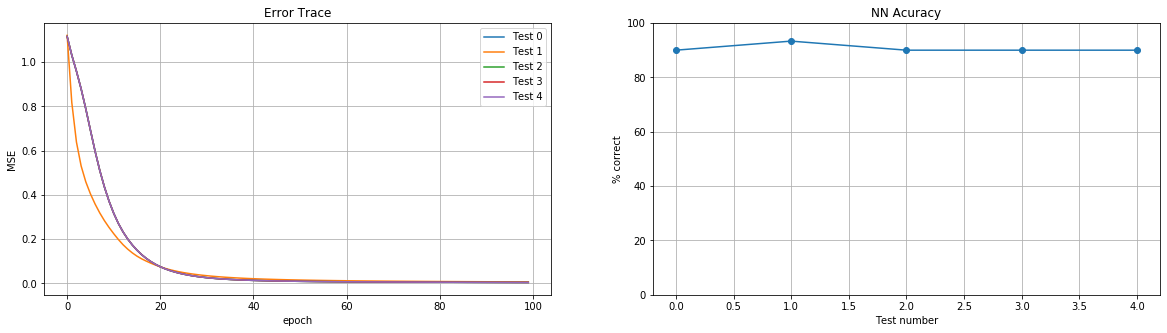

In [26]:
print_results(results)

The network with the fewest number of layers had the best performance.  It was able to correctly identify 93% of the samples while networks with > 1 layer had 90% accuracy.  In fact, all networks with > 1 layer performed exactly the same with respect to accuracy and training behavior.

### Number of units

In [27]:
%%capture
results = []
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(   [5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(   [1], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(  [10], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(  [50], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test( [500], [[5, 3], [4, 2]], [10], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 28 out of 30 samples or 93.33 percent.
Test 0 - 29 out of 30 samples or 96.67 percent.
Test 0 - 29 out of 30 samples or 96.67 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 25 out of 30 samples or 83.33 percent.


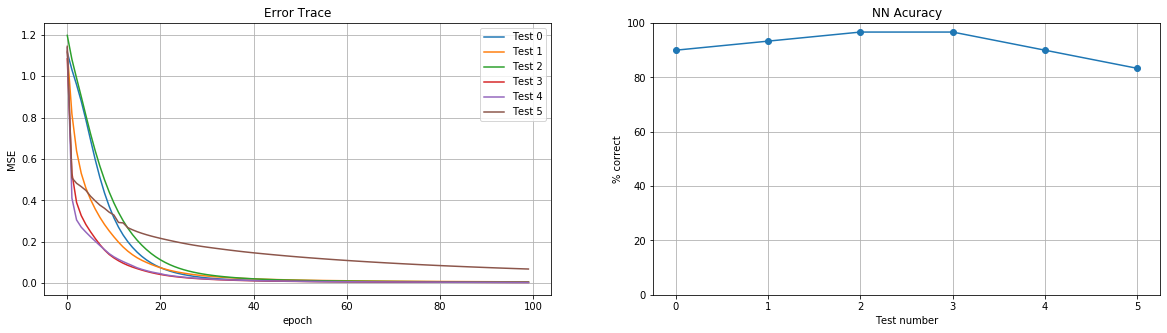

In [28]:
print_results(results)

The results are somewhat mixed.  The best performance (96% accuracy) was seen with one and ten units in the hidden layer while a value in between didn't do a well (93% accuracy).  Once we are beyond ten units, the performance continues to decrease.  The worst performance (83% accuracy) was in the network with the most units.  Given that 'test 3' trained quicker than 'test 2', the best configuration would be the network with ten units in the hidden layer.

#### Layers and Units

In [29]:
%%capture
results = []
results.append(run_test(             [5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(                [5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(                [1], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(              [2,2], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(            [3,3,3], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(        [5,5,5,5,5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([50,50,50,50,50,50], [[5, 3], [4, 2]], [10], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 28 out of 30 samples or 93.33 percent.
Test 0 - 29 out of 30 samples or 96.67 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 26 out of 30 samples or 86.67 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 26 out of 30 samples or 86.67 percent.


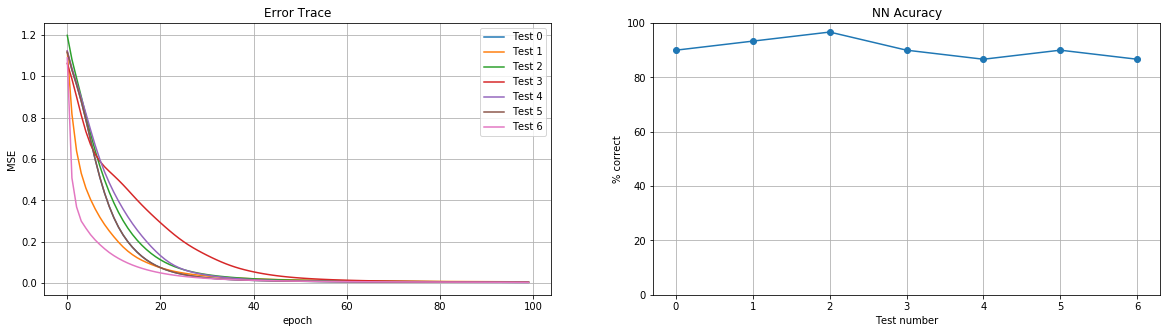

In [30]:
print_results(results)

The bets network configuration is the one with a single unit in a single hidden layer.  It correctly identified 96% of the images.  The other network with a single hidden layer but more units did almost as well by correctly identifying 93% of the images.  Overall, less units in a single layer yields better results.

### Kernel Size and Stride
##### Kernel size (1st layer)

In [31]:
%%capture
results = []
results.append(run_test([5, 5], [ [5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [ [1, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [ [5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[10, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[15, 3], [4, 2]], [10], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 28 out of 30 samples or 93.33 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 28 out of 30 samples or 93.33 percent.
Test 0 - 29 out of 30 samples or 96.67 percent.


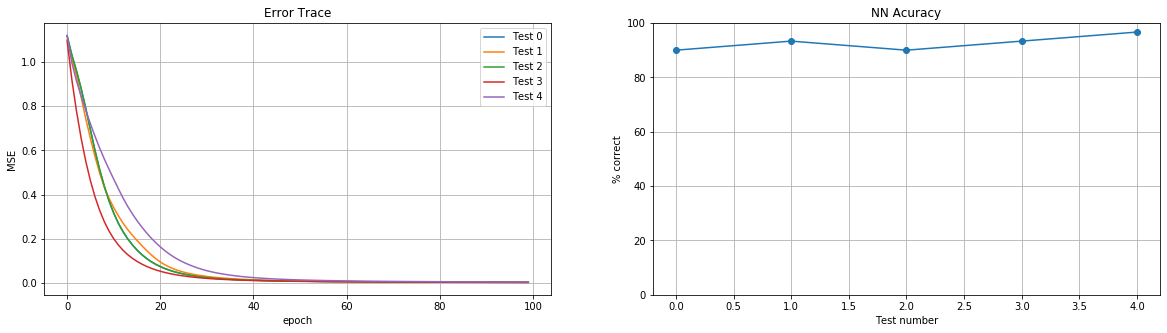

In [32]:
print_results(results)

The performance varies in a non-monotonic way based on the kernel size.  The best overall performance (96% accuracy) was seen on a network with the biggest kernel size (15).  This network was also the slowest to train, but eventually reaches the same error rate as the other networks.

##### Stride size (1st layer)

In [33]:
%%capture
results = []
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 1], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 2], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 5], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 6], [4, 2]], [10], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 26 out of 30 samples or 86.67 percent.
Test 0 - 28 out of 30 samples or 93.33 percent.
Test 0 - 28 out of 30 samples or 93.33 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.


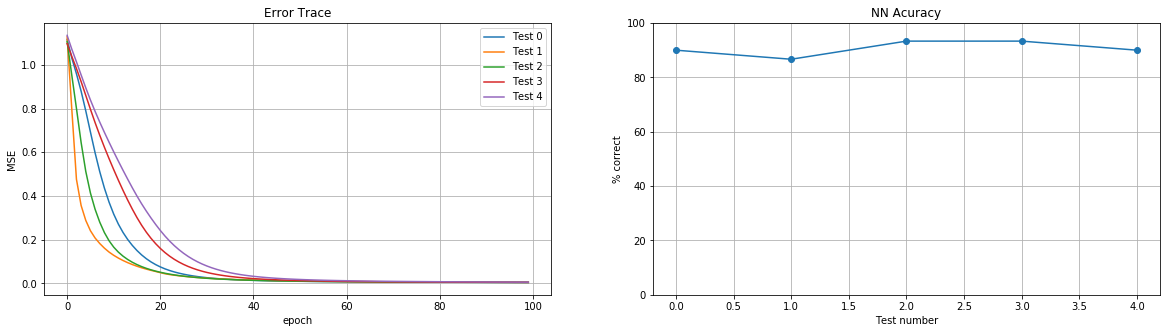

In [34]:
print_results(results)

The best results (93% accuracyc) was observed on a network with a step size of two or five.  The worst performane (86% accuracy) was seen with a step size of one.  I don't have any intuition as to why this would be, I would have assumed that a step size of one would give the most information.

#### kernel size and stride (1st layer)

In [35]:
%%capture
results = []
results.append(run_test([5, 5], [ [5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [ [1, 1], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [ [1, 5], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [ [5, 1], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[10, 1], [4, 2]], [10], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 29 out of 30 samples or 96.67 percent.
Test 0 - 28 out of 30 samples or 93.33 percent.
Test 0 - 26 out of 30 samples or 86.67 percent.
Test 0 - 29 out of 30 samples or 96.67 percent.


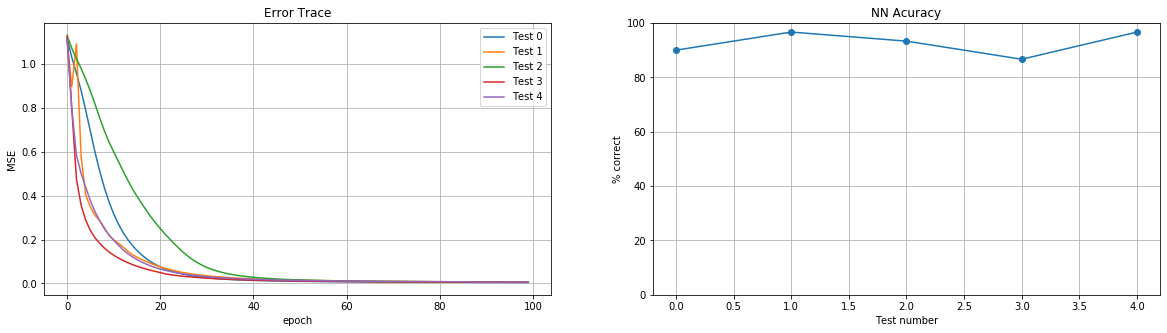

In [36]:
print_results(results)

The best result (96% accuracy) was seen with a kernel size of one or ten and a stride of one.  The worst behavior (86% accuracy) was seen with a kernel size of 5 and stride of one.  I don't have any intuition as to why these values would be better than those in between.

#### kernel size and stride (2nd layer)

In [37]:
%%capture
results = []
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 3], [1, 1]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 3], [1, 5]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 3], [5, 1]], [10], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 22 out of 30 samples or 73.33 percent.
Test 0 - 29 out of 30 samples or 96.67 percent.


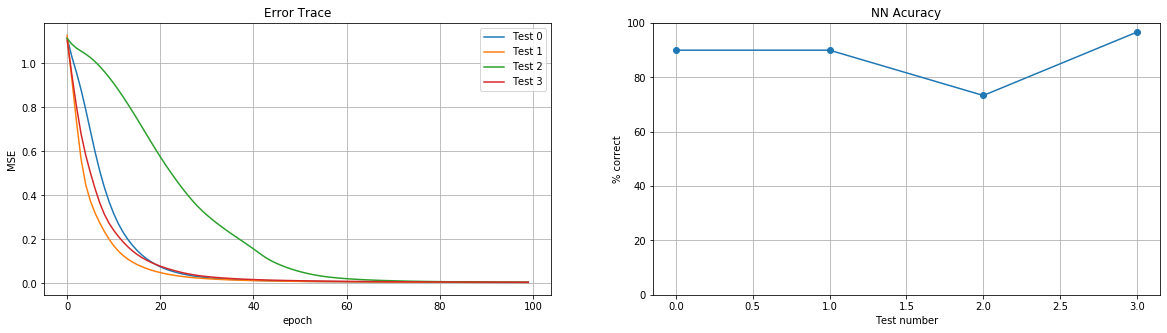

In [38]:
print_results(results)

The best performance (96% accuracy) was seen with a kernel size of five and stride of one.  Interestingly, this combination on the first layer gave the worst overall result in the previous experiment.

#### kernel size and stride (1st & 2nd layer)

In [39]:
%%capture
results = []
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 1], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 3], [1, 1]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[1, 1], [1, 1]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[3, 1], [3, 1]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 1], [5, 1]], [10], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 26 out of 30 samples or 86.67 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 10 out of 30 samples or 33.33 percent.
Test 0 - 28 out of 30 samples or 93.33 percent.
Test 0 - 28 out of 30 samples or 93.33 percent.


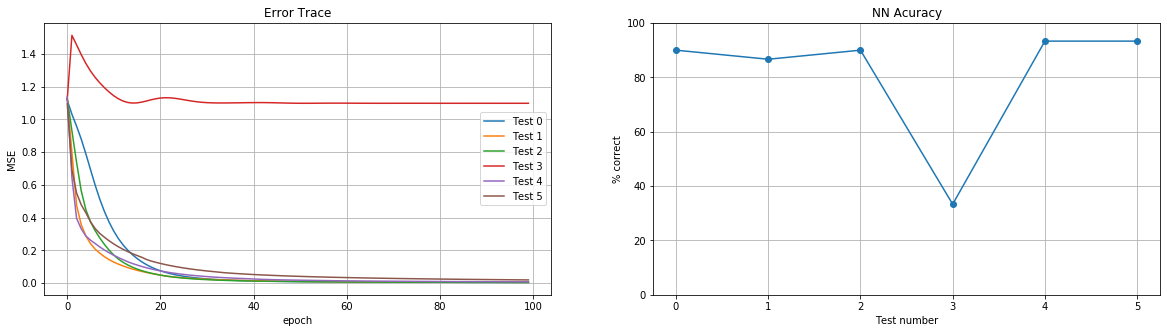

In [40]:
print_results(results)

THe best result (93% accuracy) was seen with a kernel size of three or five and stride of one.  The network with the worst behavior (33% accuracy) was seen with a kernel size of one and stride of one in the both layers.  The MSE results are also extremely bad and aligns with the accuracy observation.  Perhaps the image size is just too small and there isn't enough data to work with in each mask.

### Learning rate

In [41]:
%%capture
results = []
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.1))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.2))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.5))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.001))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.001))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 26 out of 30 samples or 86.67 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.


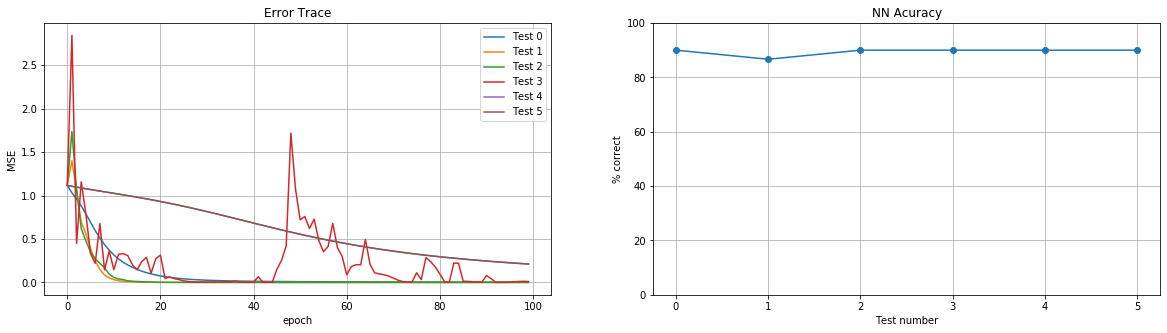

In [42]:
print_results(results)

The learning rate does not appear to have a significant impact on the overall result.  This is most likely due to the number of iterations used train the network.  A smaller number of training cycles would likely make this more pronounced.

### Number of epochs

In [43]:
%%capture
results = []
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False,   1, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False,   2, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False,   3, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False,   4, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False,   5, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False,   6, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False,   7, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False,   8, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], False,  10, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 10 out of 30 samples or 33.33 percent.
Test 0 - 16 out of 30 samples or 53.33 percent.
Test 0 - 19 out of 30 samples or 63.33 percent.
Test 0 - 21 out of 30 samples or 70.00 percent.
Test 0 - 22 out of 30 samples or 73.33 percent.
Test 0 - 24 out of 30 samples or 80.00 percent.
Test 0 - 25 out of 30 samples or 83.33 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.


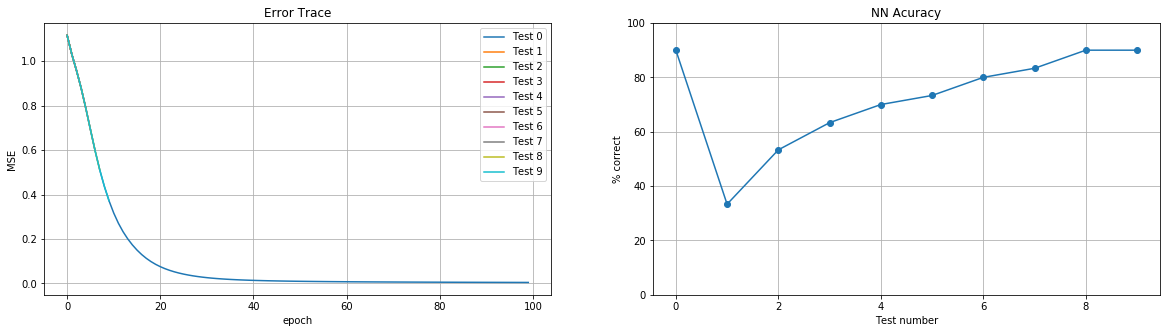

In [44]:
print_results(results)

The number of iterations below 8 makes a significant imipact on the overall performance.  Above 8, the performane plateus at 90% accuracy.  Since this is the exact same network, it makes sense that the error_trace for all experiments overlap.  They all follow the same path, but the tests with fewer iterations will be shorter.  The firs and last test are longer than the others which makes it impossible to see the other traces.

#### all parameters

In [45]:
%%capture
results = []
results.append(run_test(             [5, 5], [ [5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(                 [], [ [5, 3], [4, 2]],   [], False, 100, 0.01))
results.append(run_test(               [10], [ [5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test([50,50,50,50,50,50], [ [5, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(             [5, 5], [[10, 3], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(             [5, 5], [ [5, 1], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(             [5, 5], [ [5, 1], [4, 2]], [10], False, 100, 0.01))
results.append(run_test(             [5, 5], [ [5, 3], [4, 2]], [10], False, 100, 0.1))
results.append(run_test(             [5, 5], [ [3, 1], [3, 1]], [10], False, 100, 0.01))
results.append(run_test([50,50,50,50,50,50], [ [3, 1], [3, 1]], [10], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 0 - 28 out of 30 samples or 93.33 percent.
Test 0 - 29 out of 30 samples or 96.67 percent.
Test 0 - 26 out of 30 samples or 86.67 percent.
Test 0 - 28 out of 30 samples or 93.33 percent.
Test 0 - 26 out of 30 samples or 86.67 percent.
Test 0 - 26 out of 30 samples or 86.67 percent.
Test 0 - 26 out of 30 samples or 86.67 percent.
Test 0 - 28 out of 30 samples or 93.33 percent.
Test 0 - 27 out of 30 samples or 90.00 percent.


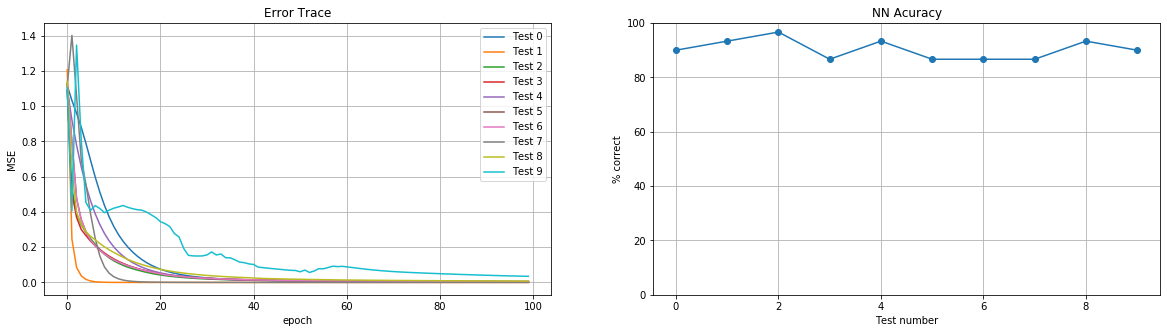

In [46]:
print_results(results)

This is an aggregatioin of the best results from all previous experiments. The best network configuration had a single layer with 10 units, followed by two layers with a kernel size and stride of 5, 3 & 4,2 respetively.  It was trained for one hundred iterations.  It's possible/likely that these observations would change if I changed the random seed or allowed it to be truly random.  I wanted to remove any randomness to see if could isolate the behavior of the network with everything else fixed.

In [47]:
Xtrain = test_set[0][:, :].reshape(-1, 1, 28, 28)
Ttrain = test_set[1][:].reshape(-1, 1)
Xtest = test_set[0][:, :].reshape(-1, 1, 28, 28)
Ttest = test_set[1][:].reshape(-1, 1)
print(f'Xtrain({Xtrain.shape}) Ttrain({Ttrain.shape})')
print(f' Xtest({Xtest.shape})  Ttest({Ttest.shape})')
print(f'Classes({np.unique(Ttrain)})')

Xtrain((10000, 1, 28, 28)) Ttrain((10000, 1))
 Xtest((10000, 1, 28, 28))  Ttest((10000, 1))
Classes([0 1 2 3 4 5 6 7 8 9])


In [48]:
%%capture
results = []
results.append(run_test([10], [ [5, 3], [4, 2]], [10], False,  100, 0.01))
results.append(run_test([10], [ [5, 3], [4, 2]], [10], False, 1000, 0.01))

Test 0 - 9633 out of 10000 samples or 96.33 percent.
Test 0 - 9996 out of 10000 samples or 99.96 percent.


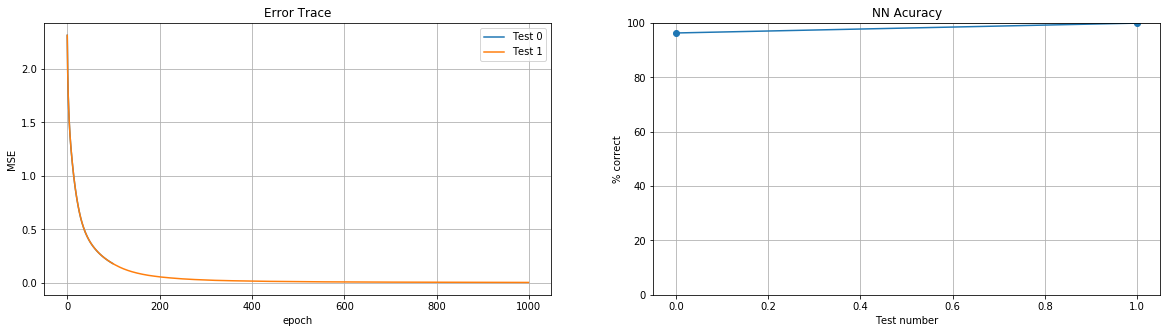

In [49]:
print_results(results)

For this experiment, I selected the network onfiguration that gave the best performance, then trained and tested on the full datasets respectively (10k samples). With 100 training iterations, which is the same number used in all previous experiments, we get virtuallly identical results obtained with a reduced data set (96% accurate).  With 1000 training iteratioins, the MSE approaches 0 and we have 99.96% corretly identified!

## Extra Credit #1

For one of your runs, display the output images of your convolutional layers and the weights for those  layers.  Discuss what you see.  Describe why the displayed weight patterns result in the output images of the first convolutional layer.

For this experiment, I am using the last configured and trained network.  It was trained for 1000 iterations and had an accuracy of 99.96%.

(-0.5, 27.5, 27.5, -0.5)

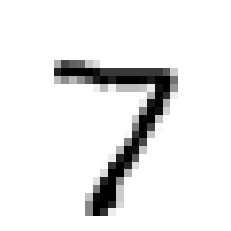

In [50]:
X_sample = Xtest[0:1, :, :, :]
plt.imshow(X_sample[0, 0, :, :], cmap='binary')
plt.axis('off')

This is the image (number 7) that will be run through the trained neural network.

### Layer 0

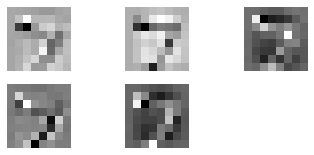

In [51]:
show_layer_output(nnet, X_sample, 0);

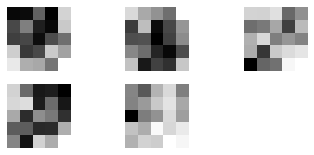

In [52]:
show_layer_weights(nnet, 0);

The previous two cells (81 & 82) are the output of each unit in the first convolutional layer and the coresponding weights.  There are five images because the network was configured with five units in the first convolutional layer.  If you squinit your eyes, the convolutional output looks like the number seven.  Lighter colors indicate higher values or that more importance is given to the 'shape'.

### Layer 1

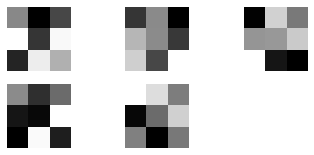

In [53]:
show_layer_output(nnet, X_sample, 1);

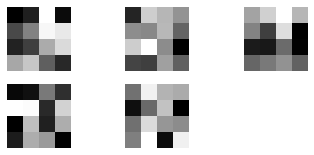

In [54]:
show_layer_weights(nnet, 1);

The previous two cells (87 & 88) are the output of each unit in the second convolutional layer and the coresponding weights. There are five images because the network was configured with five units in the second convolutional layer.  Unlike the first layer, the images in the second layer do not seem to have any resemblence of the input image.  The colors seem to be clustered into larger groups relative to the first layer.  My hypothesis is that the first layer is responsible for the main shape and the second layer amplifies the output of the previous layer.

## Extra Credit #2

Make at least one of your runs on a workstation with a GPU and run with use_gpu=True.
Also run it with use_gpu=False.  Discuss the differences in training times.

My machine doesn't have a GPU.  I get the following when trying to run this experiment  
* GPU is not available. Running on CPU.

# Grading

Download [A4grader.zip](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.zip) and extract A4grader.py from it. 

In [55]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Staab-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing if your NeuralNetwork_Convolutional can learn to classify a small 
subset of hand_drawn 0, 1, and 2 digits.

import numpy as np
import pickle, gzip

# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
Xtest = test_set[0]
traini = [3,  10,  13,  25,  28,  55,  69,  71, 101, 126, 2,   5,  14,  29,  31,  37,  39,  40,  46,  57, 1,  35,  38,  43,  47,  72,  77,  82, 106, 119]
testi = [136, 148, 157, 183, 188, 192, 194, 215, 246, 269,  74,  89,  94, 96, 107, 135, 137, 143, 145, 154, 147, 149, 172, 174, 186, 199, 208, 221, 222, 225]
Xtrain = test_set[0][traini, :].reshape(-1, 1, 28, 28)
Ttrain = test_set[1][traini].reshape(-1, 1)
Xtest = test_set[0][testi, :].reshape(-1

<Figure size 432x288 with 0 Axes>